## PyTorch-LSTM

**LSTM - Long Short Term Memory networks** are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to have a long term memory and can. remember "context" for sometime. Recently they have been very successful in many machine learning tasks. In the sheet below we will apply LSTMs to time series predictions. A good introduction to **LSTMs** can be found here 

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

we will be using this dataset for our timeseries predictions.
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#


In [2]:
df = pd.read_csv('../data/traffic/Metro_Interstate_Traffic_Volume.csv')
len(df)

48204

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
#Drop na
df.dropna(inplace=True)
len(df)

48204

In [5]:
#For purpose of this exercise delete everything except traffic_volume
df.drop(['holiday','temp','rain_1h','snow_1h', 'clouds_all', 'weather_main','weather_description','date_time'], inplace=True, axis=1)

For this example lets take 4000 rows of the data

In [7]:
df = df[0:4000]

In [8]:
# Define a test size
test_size = 168 # 7days * 24 

# Create train and test sets
train_set = df[:-test_size].values
test_set = df[-test_size:].values

In [9]:
train_set

array([[5545],
       [4516],
       [4767],
       ...,
       [4600],
       [4455],
       [4776]])

In [10]:
test_set

array([[4492],
       [4588],
       [4725],
       [4301],
       [3394],
       [2782],
       [2929],
       [2441],
       [1799],
       [1093],
       [ 785],
       [ 612],
       [ 368],
       [ 252],
       [ 454],
       [ 454],
       [ 696],
       [ 696],
       [ 996],
       [ 996],
       [1633],
       [1633],
       [2341],
       [3229],
       [3488],
       [3488],
       [3873],
       [4204],
       [4277],
       [4073],
       [4473],
       [3845],
       [3509],
       [2693],
       [2191],
       [1837],
       [1289],
       [1056],
       [ 472],
       [ 260],
       [ 260],
       [ 229],
       [ 291],
       [ 291],
       [ 778],
       [2459],
       [2459],
       [2459],
       [2459],
       [5615],
       [5615],
       [5615],
       [6920],
       [4232],
       [4232],
       [4271],
       [4271],
       [4734],
       [5108],
       [5535],
       [6374],
       [5941],
       [4384],
       [2940],
       [2545],
       [2079],
       [14

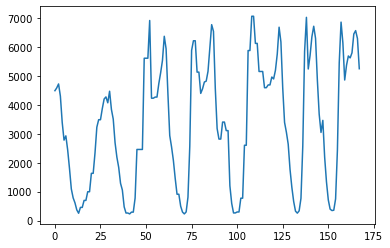

In [11]:
plt.plot(test_set)

Scale the data to -1,1.

In [12]:
#Scale the data between -1 1
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

Normalize the training dataset

In [13]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

Convert the data to a format which PyTorch can consume

In [14]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 168 #1 week

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data) 

3664

In [15]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([ 0.5345,  0.2432,  0.3143,  0.3876,  0.3570,  0.4315,  0.5456,  0.6676,
          0.6042,  0.3151, -0.0334, -0.2472, -0.3669, -0.6025, -0.7627, -0.8921,
         -0.9445, -0.9581, -0.9315, -0.8049, -0.2659,  0.5708,  0.8080,  0.5136,
          0.4077,  0.3482,  0.4757,  0.5762,  0.7022,  0.2735, -0.0187, -0.2149,
         -0.2888, -0.5323, -0.7480, -0.8661, -0.9309, -0.9471, -0.9315, -0.7990,
         -0.2636,  0.5753,  0.9437,  0.6591,  0.4677,  0.2678,  0.3474,  0.4097,
          0.4306,  0.5221,  0.5821,  0.7460,  0.6795,  0.3539, -0.0436, -0.1755,
         -0.2364, -0.4714, -0.7053, -0.8579, -0.9255, -0.9312, -0.3307,  0.5323,
          0.8412,  0.5314,  0.4943,  0.3151,  0.4417,  0.6266,  0.6540,  0.6939,
          0.6996,  0.6829,  0.7112,  0.4890,  0.1149, -0.0830, -0.1942, -0.3417,
         -0.5167, -0.6869, -0.8321, -0.8811, -0.9190, -0.8406, -0.6526, -0.4488,
         -0.0892,  0.1702,  0.3409,  0.4343,  0.5696,  0.4012,  0.3873,  0.4236,
          0.3870,  0.3177,  

Define an **LSTM** model, with 100 hidden states.

In [16]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=168, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

Setup the model, criterion and optimizer

In [17]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 168)
  (linear): Linear(in_features=168, out_features=1, bias=True)
)

Count number of parameters in the model

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   672
112896
   672
   672
   168
     1
______
115081


Lets train the model

In [20]:
epochs = 10

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02317893
Epoch:  2 Loss: 0.02260499
Epoch:  3 Loss: 0.02174702
Epoch:  4 Loss: 0.02022834
Epoch:  5 Loss: 0.01810641
Epoch:  6 Loss: 0.01804269
Epoch:  7 Loss: 0.01560365
Epoch:  8 Loss: 0.01608639
Epoch:  9 Loss: 0.01399016
Epoch: 10 Loss: 0.01333253

Duration: 12929 seconds


In [21]:
future = 168

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.25325530767440796,
 0.22441157698631287,
 0.14631766080856323,
 0.04050733894109726,
 -0.06794317811727524,
 -0.18915650248527527,
 -0.31379833817481995,
 -0.44562089443206787,
 -0.5859788656234741,
 -0.7258116602897644,
 -0.8485443592071533,
 -0.9399544596672058,
 -0.9883280396461487,
 -0.9701880216598511,
 -0.8292446732521057,
 -0.47972264885902405,
 0.0634031817317009,
 0.36768731474876404,
 0.3564590811729431,
 0.2588796317577362,
 0.23494794964790344,
 0.2708478271961212,
 0.3125348389148712,
 0.3481467664241791,
 0.398053377866745,
 0.45061519742012024,
 0.45663419365882874,
 0.38683417439460754,
 0.25999853014945984,
 0.12637153267860413,
 0.019988588988780975,
 -0.07236810028553009,
 -0.16732561588287354,
 -0.27002209424972534,
 -0.3801162838935852,
 -0.4980246126651764,
 -0.6211956739425659,
 -0.7418017387390137,
 -0.8504962921142578,
 -0.9378758668899536,
 -0.9892715811729431,
 -0.9783325791358948,
 -0.8574575185775757,
 -0.5555151700973511,
 -0.052633557468652725,
 0.3007

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[4551.49774671],
       [4449.62168992],
       [4173.79397798],
       [3800.07192114],
       [3417.02469489],
       [2988.89923322],
       [2548.66426957],
       [2083.06700087],
       [1587.32264662],
       [1093.43321586],
       [ 659.94132328],
       [ 337.08084846],
       [ 166.22536397],
       [ 230.2959075 ],
       [ 728.10781407],
       [1962.61960423],
       [3880.94003788],
       [4955.67159569],
       [4916.0134747 ],
       [4571.36285937],
       [4486.83615816],
       [4613.63452566],
       [4760.87305105],
       [4886.65437901],
       [5062.92453063],
       [5248.57287729],
       [5269.831972  ],
       [5023.29830396],
       [4575.31480849],
       [4103.34425342],
       [3727.59969631],
       [3401.39586979],
       [3066.0059247 ],
       [2703.28196311],
       [2314.42928529],
       [1897.97706807],
       [1462.93687963],
       [1036.95625877],
       [ 653.04709625],
       [ 344.42243814],
       [ 162.8927753 ],
       [ 201.529

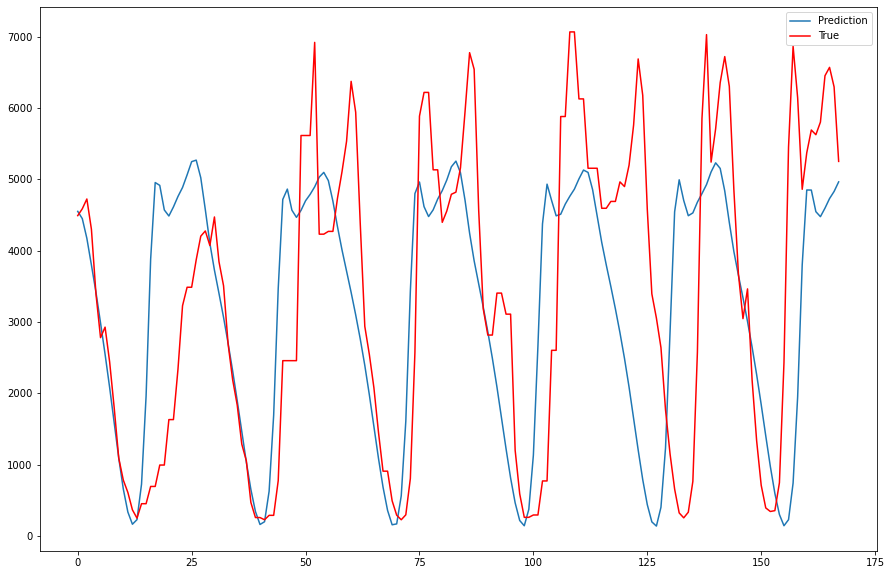

In [29]:
plt.figure(figsize=(15,10))
plt.plot(true_predictions, label='Prediction')
plt.plot(test_set, color='r', label='True')
plt.legend()

We can see from the above plot that predictions are not that bad..given we only trained for 10 epochs and only used 4000 datapoints, and didn't use the other features.